# Reinforcement Learning Model

# Single Agent and Enviroment without Grid

In [ ]:
import gym
from gym import spaces
import numpy as np

class TrainSchedulingEnv(gym.Env):
    def __init__(self):
        super(TrainSchedulingEnv, self).__init__()

        # Stations and their routes (in minutes)
        self.stations = ["Chennai", "Madurai", "Coimbatore", "Tiruchirappalli", "Salem"]
        self.routes = {
            "Chennai": {"Madurai": 420, "Coimbatore": 480, "Tiruchirappalli": 330},
            "Madurai": {"Chennai": 420, "Tiruchirappalli": 120, "Coimbatore": 240},
            "Coimbatore": {"Chennai": 480, "Madurai": 240, "Salem": 210},
            "Tiruchirappalli": {"Chennai": 330, "Madurai": 120, "Salem": 150},
            "Salem": {"Coimbatore": 210, "Tiruchirappalli": 150}
        }
        self.num_stations = len(self.stations)

        # Train details
        self.num_trains = 5
        self.max_tracks_per_station = 3

        # Weather and maintenance
        self.weather_conditions = {route: np.random.uniform(0.8, 1.2) for route in self.routes.keys()}
        self.maintenance_schedule = {route: np.random.choice([0, 1], p=[0.9, 0.1]) for route in self.routes.keys()}  # 10% chance of maintenance

        # Passenger demand (randomized at reset)
        self.passenger_demand = None

        # Action and state spaces
        self.action_space = spaces.MultiDiscrete([self.num_stations] * self.num_trains)  # Next station for each train
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.num_trains, 6), dtype=np.float32
        )  # [current_station, delay, destination, progress, weather, maintenance]
        self.reset()

    def reset(self):
        self.train_states = np.zeros((self.num_trains, 6))
        self.passenger_demand = np.random.randint(50, 200, size=(self.num_stations, self.num_stations))
        for train_id in range(self.num_trains):
            self.train_states[train_id, 0] = np.random.randint(0, self.num_stations)  # Random starting station
            self.train_states[train_id, 2] = np.random.randint(0, self.num_stations)  # Random destination
        return self.train_states

    def step(self, actions):
        reward = 0
        done = False

        for train_id, next_station_index in enumerate(actions):
            current_station_index = int(self.train_states[train_id, 0])
            destination_station_index = int(self.train_states[train_id, 2])
            current_station = self.stations[current_station_index]
            next_station = self.stations[next_station_index]

            # Check if route exists
            if next_station not in self.routes[current_station]:
                reward -= 50  # Heavy penalty for invalid route choice
                continue

            # Travel time, weather, and maintenance impact
            travel_time = self.routes[current_station][next_station]
            weather_impact = self.weather_conditions[current_station]
            maintenance = self.maintenance_schedule[current_station]

            if maintenance:
                reward -= 30  # Penalty for choosing a route under maintenance
                continue

            adjusted_travel_time = travel_time * weather_impact
            self.train_states[train_id, 1] += adjusted_travel_time  # Add delay
            self.train_states[train_id, 0] = next_station_index  # Update current station

            # Reward based on passenger satisfaction
            passengers_satisfied = self.passenger_demand[current_station_index, destination_station_index]
            reward += passengers_satisfied * 2 - adjusted_travel_time  # Positive reward for satisfying demand and minimizing delay

            # Check if destination reached
            if current_station_index == destination_station_index:
                reward += 100  # Large reward for reaching destination
                done = True  # Simulation ends when a train reaches its destination

        return self.train_states, reward, done, {}

    def render(self, mode="human"):
        print(f"Train States: {self.train_states}")
        for train_id, train_state in enumerate(self.train_states):
            current_station = self.stations[int(train_state[0])]
            destination_station = self.stations[int(train_state[2])]
            print(
                f"Train {train_id}: Current Station={current_station}, Destination={destination_station}, "
                f"Delay={train_state[1]:.2f} minutes"
            )

# Create environment
env = TrainSchedulingEnv()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Wrap the environment
env = make_vec_env(lambda: TrainSchedulingEnv(), n_envs=1)

# Train the PPO model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

# Test the model
obs = env.reset()
for _ in range(100):
    action, _ = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()


## Even tried to simulate realworld train paths of india to check whether this solution works but it fails 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
import time  # To add delay for visualization

# Load the dataset
train_data = pd.read_csv('Train_details_22122017.csv', dtype={'Distance': str})

# Convert the 'Distance' column to numeric, coercing errors into NaN
train_data['Distance'] = pd.to_numeric(train_data['Distance'], errors='coerce')

# Select data for multiple trains (e.g., Train No 107, 108, 109)
train_numbers = [107, 108, 109]
train_subset = train_data

# Create a graph with NetworkX
G = nx.Graph()

# Add stations as nodes
for _, row in train_subset.iterrows():
    G.add_node(row["Station Name"], station_code=row["Station Code"])

# Add routes (edges) between stations for each train
for i in range(1, len(train_subset)):
    source = train_subset.iloc[i-1]
    target = train_subset.iloc[i]

    if pd.notna(source["Distance"]) and pd.notna(target["Distance"]):
        G.add_edge(
            source["Station Name"],
            target["Station Name"],
            distance=target["Distance"] - source["Distance"],
            departure_time=target["Departure Time"],
            arrival_time=source["Arrival time"]
        )

# Check the graph
print(f"Number of nodes (stations) in the graph: {len(G.nodes())}")
print(f"Number of edges (routes) in the graph: {len(G.edges())}")

# Ensure that there are nodes to create the action space
if len(G.nodes()) == 0:
    raise ValueError("Graph has no nodes. Ensure the dataset contains valid station data.")

# Define the environment
class TrainMovementEnv(gym.Env):
    def __init__(self, graph):
        super(TrainMovementEnv, self).__init__()
        self.graph = graph
        self.stations = list(graph.nodes())  # List of station names
        self.current_station = 0  # Start at the first station
        self.action_space = spaces.Discrete(len(self.stations))  # Actions: move to a station
        self.observation_space = spaces.Discrete(len(self.stations))  # Observations: current station

    def reset(self):
        self.current_station = 0  # Reset to the first station
        return self.current_station

    def step(self, action):
        if action < 0 or action >= len(self.stations):
            return self.current_station, -1, False, {}

        # Move to the selected station
        next_station = self.stations[action]
        if next_station in self.graph[self.stations[self.current_station]]:
            self.current_station = action
            return self.current_station, 0, False, {}  # No reward, still moving
        else:
            return self.current_station, -1, False, {}  # Invalid move

    def render(self):
        # Plot the graph with the current station highlighted
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(self.graph, seed=42)  # Use a layout for better positioning
        nx.draw(self.graph, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10)

        # Highlight the current station in a different color
        current_station = self.stations[self.current_station]
        nx.draw_networkx_nodes(self.graph, pos, nodelist=[current_station], node_size=5000, node_color='red')

        plt.title(f"Train is at {current_station}")
        plt.show()

        # Adding a small delay to visualize the movement
        time.sleep(1)

# Initialize environment with the graph of train stations
env = TrainMovementEnv(G)

# Example of simulating one episode
obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Choose a random action (move to a random station)
    obs, reward, done, info = env.step(action)
    env.render()  # Render the current state after each step


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd

# Example: Create a simple graph
G = nx.Graph()
G.add_edge("Mumbai", "Delhi", weight=1000)
G.add_edge("Delhi", "Kolkata", weight=1500)
G.add_edge("Mumbai", "Chennai", weight=1300)

# Plot with NetworkX
pos = nx.spring_layout(G)  # You can replace with geospatial coordinates
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()


# Mutli Agent and Enviroment with Grid

## First deliverable, Reinforcement learning model for train scheduling optimization

In [1]:
import numpy as np
import random

class RailEnvironment:
    def __init__(self, grid_size=(10, 10), n_agents=3):
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.grid = np.full(grid_size, -1)  # Initialize all cells as non-rail area (-1)
        self.agents = []
        self._initialize_environment()

    def _initialize_environment(self):
        # Create railway paths (values >= 0) randomly
        num_paths = random.randint(10, 20)
        for _ in range(num_paths):
            x, y = np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1])
            self.grid[x, y] = 0  # Mark railway paths as >= 0

        # Assign random areas for maintenance (2) and extreme weather (3)
        num_maintenance = random.randint(2, 5)
        num_weather = random.randint(2, 5)

        for _ in range(num_maintenance):
            x, y = np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1])
            if self.grid[x, y] >= 0:  # Ensure it is part of a railway path
                self.grid[x, y] = 2

        for _ in range(num_weather):
            x, y = np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1])
            if self.grid[x, y] >= 0:  # Ensure it is part of a railway path
                self.grid[x, y] = 3

        # Place agents (trains) at random railway stations
        for i in range(self.n_agents):
            start = self._get_random_railway_position()
            target = self._get_random_railway_position()
            while target == start:
                target = self._get_random_railway_position()
            self.agents.append({
                "id": i,
                "start": start,
                "target": target,
                "position": start,
                "done": False,
                "reward": 0
            })
            self.grid[start] = 1  # Mark the agent's initial position as occupied

    def _get_random_railway_position(self):
        while True:
            x, y = np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1])
            if self.grid[x, y] >= 0:  # Ensure the position is part of a railway path
                return (x, y)

    def step(self, actions):
        rewards = {}
        done = True
        for agent, action in zip(self.agents, actions):
            if agent["done"]:
                rewards[agent["id"]] = 0
                continue

            # Compute new position
            new_position = self._move(agent["position"], action)
            if not self._is_valid(new_position):
                rewards[agent["id"]] = -5  # Invalid move penalty
                continue

            # Update position and check for rewards
            current_cell_value = self.grid[new_position]
            self.grid[agent["position"]] = 0  # Mark current position as free
            agent["position"] = new_position
            self.grid[new_position] = 1  # Mark new position as occupied

            if new_position == agent["target"]:
                agent["done"] = True
                rewards[agent["id"]] = 10  # Reaching target reward
            elif current_cell_value == 3:
                rewards[agent["id"]] = -2  # Extreme weather condition penalty
            elif current_cell_value == 2:
                rewards[agent["id"]] = -3  # Maintenance area penalty
            else:
                rewards[agent["id"]] = -1  # Normal step penalty

            done = done and agent["done"]

        return self.grid, rewards, done

    def _move(self, position, action):
        moves = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1),   # Right
            4: (0, 0)    # Wait
        }
        return (position[0] + moves[action][0], position[1] + moves[action][1])

    def _is_valid(self, position):
        return (0 <= position[0] < self.grid_size[0] and
                0 <= position[1] < self.grid_size[1] and
                self.grid[position] >= 0 and  # Must be part of the railway path
                self.grid[position] != 1)    # Must not be occupied

    def reset(self):
        self.__init__(self.grid_size, self.n_agents)
        return self.grid


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [6]:
class DQLAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=2000)
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Random action
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item()
            target_f = self.model(state).detach()
            target_f[0][action] = target
            self.model.zero_grad()
            loss = nn.functional.mse_loss(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [5]:
if __name__ == "__main__":
    env = RailEnvironment(grid_size=(10, 10), n_agents=5)  # Environment with multiple agents
    agents = [
        DQLAgent(state_size=env.grid.size, action_size=5) for _ in range(env.n_agents)
    ]  # One DQLAgent for each agent
    episodes = 1000
    batch_size = 32

    for episode in range(episodes):
        state = env.reset()  # Reset environment
        states = [state.flatten()] * env.n_agents  # Initial states for all agents
        done = False
        total_rewards = [0] * env.n_agents  # Track total reward for each agent

        while not done:
            # Agents select actions independently
            actions = [agent.act(state.flatten()) for agent, state in zip(agents, states)]

            # Perform actions in the environment
            next_state, rewards, done = env.step(actions)

            # Update each agent's experience and track rewards
            next_states = [next_state.flatten()] * env.n_agents
            for i, agent in enumerate(agents):
                reward = rewards[i]
                agent.remember(states[i], actions[i], reward, next_states[i], done)
                total_rewards[i] += reward

            states = next_states  # Update states for the next step

        # Replay and train each agent
        for agent in agents:
            agent.replay(batch_size)

        # Logging the results for this episode
        total_reward = sum(total_rewards)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Average Reward per Agent: {total_reward / env.n_agents:.2f}")

        # Optionally, you can adjust epsilon decay for each agent if needed
        for agent in agents:
            if hasattr(agent, 'epsilon') and hasattr(agent, 'epsilon_min'):
                agent.epsilon = max(agent.epsilon_min, agent.epsilon * 0.995)  # Decay epsilon


Episode 1/1000, Total Reward: -10, Average Reward per Agent: -2.00
Episode 2/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 3/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 4/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 5/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 6/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 7/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 8/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 9/1000, Total Reward: -47, Average Reward per Agent: -9.40
Episode 10/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 11/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 12/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 13/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 14/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 15/1000, Total Reward: -46, Average Reward per Ag

Episode 122/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 123/1000, Total Reward: -67, Average Reward per Agent: -13.40
Episode 124/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 125/1000, Total Reward: -42, Average Reward per Agent: -8.40
Episode 126/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 127/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 128/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 129/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 130/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 131/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 132/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 133/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 134/1000, Total Reward: -39, Average Reward per Agent: -7.80
Episode 135/1000, Total Reward: -63, Average Reward per Agent: -12.60
Episode 136/1000, Total Reward: 

Episode 241/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 242/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 243/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 244/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 245/1000, Total Reward: -65, Average Reward per Agent: -13.00
Episode 246/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 247/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 248/1000, Total Reward: -10, Average Reward per Agent: -2.00
Episode 249/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 250/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 251/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 252/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 253/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 254/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 255/1000, Total Reward: -

Episode 361/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 362/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 363/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 364/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 365/1000, Total Reward: -89, Average Reward per Agent: -17.80
Episode 366/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 367/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 368/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 369/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 370/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 371/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 372/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 373/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 374/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 375/1000, Total Reward: -

Episode 480/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 481/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 482/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 483/1000, Total Reward: -42, Average Reward per Agent: -8.40
Episode 484/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 485/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 486/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 487/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 488/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 489/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 490/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 491/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 492/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 493/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 494/1000, Total Reward: -2

Episode 599/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 600/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 601/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 602/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 603/1000, Total Reward: -42, Average Reward per Agent: -8.40
Episode 604/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 605/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 606/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 607/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 608/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 609/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 610/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 611/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 612/1000, Total Reward: -10, Average Reward per Agent: -2.00
Episode 613/1000, Total Reward: -2

Episode 718/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 719/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 720/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 721/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 722/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 723/1000, Total Reward: -10, Average Reward per Agent: -2.00
Episode 724/1000, Total Reward: -67, Average Reward per Agent: -13.40
Episode 725/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 726/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 727/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 728/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 729/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 730/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 731/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 732/1000, Total Reward: -

Episode 837/1000, Total Reward: -63, Average Reward per Agent: -12.60
Episode 838/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 839/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 840/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 841/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 842/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 843/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 844/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 845/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 846/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 847/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 848/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 849/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 850/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 851/1000, Total Reward: -

Episode 956/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 957/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 958/1000, Total Reward: -26, Average Reward per Agent: -5.20
Episode 959/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 960/1000, Total Reward: -10, Average Reward per Agent: -2.00
Episode 961/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 962/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 963/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 964/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 965/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 966/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 967/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 968/1000, Total Reward: -25, Average Reward per Agent: -5.00
Episode 969/1000, Total Reward: -46, Average Reward per Agent: -9.20
Episode 970/1000, Total Reward: -2

# Second Deliverable: Simulation and evaluation of model based on historical performance

In [25]:
import numpy as np
import random
import math
import heapq

class RealWorldRailEnvironment:
    def __init__(self, grid_size=(100, 100), n_agents=3, station_coords=None):
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.grid = np.full(grid_size, -1)  # Initialize grid with non-rail area (-1)
        self.agents = []
        self.station_map = station_coords or {}  # Map stations to grid coordinates
        self._initialize_environment()

    def _initialize_environment(self):
        # Mark stations
        for station, location in self.station_map.items():
            self.grid[location] = 0  # Stations are railway nodes

        # Connect stations with realistic routes
        station_locations = list(self.station_map.values())
        for i in range(len(station_locations) - 1):
            self._draw_route(station_locations[i], station_locations[i + 1])

        # Randomly assign agents to simulate trains
        for i in range(self.n_agents):
            start_station = random.choice(list(self.station_map.keys()))
            target_station = random.choice(list(self.station_map.keys()))
            while start_station == target_station:
                target_station = random.choice(list(self.station_map.keys()))

            self.agents.append({
                "id": i,
                "start": self.station_map[start_station],
                "target": self.station_map[target_station],
                "position": self.station_map[start_station],
                "done": False,
                "reward": 0,
                "fuel_consumption": 0.0  # Track fuel consumption
            })
            self.grid[self.station_map[start_station]] = 1  # Mark starting positions

    def _draw_route(self, start, end):
        """Connect two stations using A* pathfinding."""
        path = self._a_star(start, end)
        for x, y in path:
            if self.grid[x, y] == -1:  # Avoid overwriting stations
                self.grid[x, y] = 0  # Railway track

    def _a_star(self, start, end):
        """A* pathfinding algorithm for realistic routes."""
        def heuristic(a, b):
            return abs(a[0] - b[0]) + abs(a[1] - b[1])  # Manhattan distance

        open_set = []
        heapq.heappush(open_set, (0, start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: heuristic(start, end)}

        while open_set:
            _, current = heapq.heappop(open_set)

            if current == end:
                return self._reconstruct_path(came_from, current)

            for neighbor in self._get_neighbors(current):
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, end)
                    if neighbor not in [item[1] for item in open_set]:
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))

        return []  # No path found

    def _get_neighbors(self, position):
        """Get valid neighbors for A* algorithm."""
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        neighbors = []
        for dx, dy in directions:
            x, y = position[0] + dx, position[1] + dy
            if 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1] and self.grid[x, y] != 1:
                neighbors.append((x, y))
        return neighbors

    def _reconstruct_path(self, came_from, current):
        """Reconstruct the path from A*."""
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path

    def step(self, actions):
        rewards = {}
        done = True
        for agent, action in zip(self.agents, actions):
            if agent["done"]:
                rewards[agent["id"]] = 0
                continue

            new_position = self._move(agent["position"], action)
            if not self._is_valid(new_position):
                rewards[agent["id"]] = -5  # Invalid move penalty
                continue

            # Calculate distance traveled for fuel consumption
            distance = self._calculate_distance(agent["position"], new_position)
            agent["fuel_consumption"] += distance * 0.5  # Example: 0.5L/km fuel consumption

            # Update position and check rewards
            self.grid[agent["position"]] = 0  # Free current position
            agent["position"] = new_position
            self.grid[new_position] = 1  # Occupy new position

            if new_position == agent["target"]:
                agent["done"] = True
                rewards[agent["id"]] = 10  # Target reached reward
            else:
                rewards[agent["id"]] = -1  # Step penalty

            done = done and agent["done"]

        return self.grid, rewards, done

    def _move(self, position, action):
        """Move based on the action."""
        moves = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1),   # Right
            4: (0, 0)    # Wait
        }
        return (position[0] + moves[action][0], position[1] + moves[action][1])

    def _is_valid(self, position):
        """Check if the position is valid."""
        return (0 <= position[0] < self.grid_size[0] and
                0 <= position[1] < self.grid_size[1] and
                self.grid[position] >= 0 and
                self.grid[position] != 1)

    def _calculate_distance(self, pos1, pos2):
        """Calculate Euclidean distance."""
        return math.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2)

    def reset(self):
        """Reset the environment."""
        self.__init__(self.grid_size, self.n_agents, self.station_map)
        return self.grid


In [26]:
def simulate_distance_comparison(env, agents, episodes, batch_size, real_world_distances):
    best_simulated_distances = [float("inf")] * env.n_agents
    best_results = []

    for episode in range(episodes):
        state = env.reset()
        states = [state.flatten()] * env.n_agents
        done = False
        total_distance = [0] * env.n_agents

        while not done:
            # Agents select actions independently
            actions = [agent.act(state.flatten()) for agent, state in zip(agents, states)]
            next_state, rewards, done = env.step(actions)
            next_states = [next_state.flatten()] * env.n_agents

            # Calculate distances for each agent
            for i in range(env.n_agents):
                total_distance[i] += env._calculate_distance(
                    env.agents[i]["position"], next_state.flatten()
                )

            states = next_states

        # Store the best distance for each agent
        for i in range(env.n_agents):
            existing_result = next((result for result in best_results if result["agent_id"] == i), None)
            if existing_result:
                # Update if the current distance is better
                if total_distance[i] < existing_result["simulated_distance"]:
                    existing_result["simulated_distance"] = total_distance[i]
            else:
            # Add a new result for the agent
                best_results.append(
                {
                    "agent_id": i,
                    "real_world_distance": real_world_distances[i],
                    "simulated_distance": total_distance[i],
                }
                )


        # Replay for training
        for agent in agents:
            agent.replay(batch_size)

    # Output best results
    print("\n--- Distance Comparison Results ---")
    for result in best_results:
        print(
            f"Agent {result['agent_id']}:\n"
            f"- Real-World Distance: {result['real_world_distance']} km\n"
            f"- Best Simulated Distance: {result['simulated_distance']} km\n"
            f"- Improvement: {100 * (result['real_world_distance'] - result['simulated_distance']) / result['real_world_distance']:.2f}%\n"
        )
        
    real_world_distances = [result["real_world_distance"] for result in best_results]
    best_simulated_distances = [result["simulated_distance"] for result in best_results]
    visualize_comparison(real_world_distances, best_simulated_distances)



--- Distance Comparison Results ---
Agent 0:
- Real-World Distance: 1400 km
- Best Simulated Distance: 15.556349186104045 km
- Improvement: 98.89%

Agent 1:
- Real-World Distance: 1380 km
- Best Simulated Distance: 15.556349186104045 km
- Improvement: 98.87%

Agent 2:
- Real-World Distance: 1420 km
- Best Simulated Distance: 15.556349186104045 km
- Improvement: 98.90%



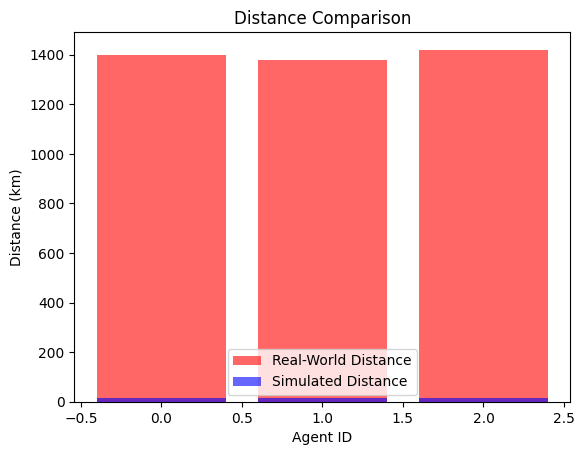

In [27]:
if __name__ == "__main__":
    # Example real-world distances for a route (in km)
    real_world_distances = [1400, 1380, 1420]  # Example for 3 trains
    
    # Example station data
    station_coords = {
        "Delhi": (10, 10),
        "Agra": (20, 15),
        "Gwalior": (30, 20),
        "Jhansi": (40, 30),
        "Bhopal": (60, 50),
        "Mumbai": (90, 90),
    }

    # Initialize the environment and agents
    env = RealWorldRailEnvironment(grid_size=(100, 100), n_agents=len(real_world_distances), station_coords=station_coords)
    agents = [DQLAgent(state_size=env.grid.size, action_size=5) for _ in range(env.n_agents)]
    
    # Run the simulation and compare results
    simulate_distance_comparison(env, agents, episodes=1000, batch_size=32, real_world_distances=real_world_distances)
    


In [17]:
import matplotlib.pyplot as plt

def visualize_comparison(real_world_distances, simulated_distances):
    agents = range(len(real_world_distances))
    plt.bar(agents, real_world_distances, label="Real-World Distance", color="red", alpha=0.6)
    plt.bar(agents, simulated_distances, label="Simulated Distance", color="blue", alpha=0.6)
    plt.xlabel("Agent ID")
    plt.ylabel("Distance (km)")
    plt.title("Distance Comparison")
    plt.legend()
    plt.show()
